In [345]:
import pandas as pd
import numpy as np
import seaborn as sns

import yfinance as yf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ValueWarning)

In [346]:
ticker_symbol = 'AAPL'
data = yf.Ticker(ticker_symbol)

In [347]:
prices = data.history(start='2021-01-01', end='2021-04-10').Close

Text(0, 0.5, 'Share Price')

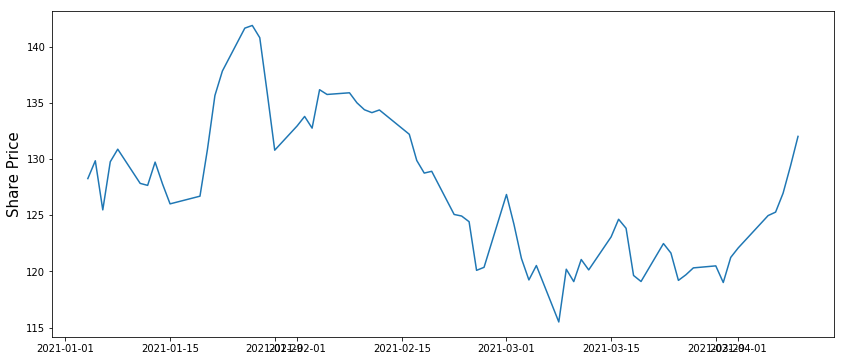

In [348]:
plt.figure(figsize=(14,6))
plt.plot(prices)
plt.ylabel('Share Price', fontsize=15)

## Clearly Prices are not stationary, cannnot fit time series model directly to price data

Text(0, 0.5, 'Daily Return on Apple Share')

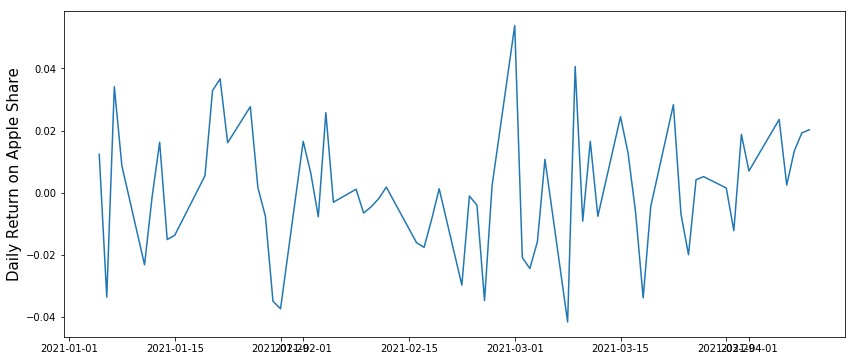

In [349]:
returns = prices.pct_change().dropna()
plt.figure(figsize=(14, 6))
plt.plot(returns)
plt.ylabel("Daily Return on Apple Share", fontsize=15)

### Looks like Stationary, 3 type of Stationary:- 

     1. Trend Stationary
     2. Seasonal Stationary
     3. Strictly Stationary : Joint Distribution of observations

### Augmented Dickey-fuller test (Unit root test)

### Null: Time series data is not stationary
### Alternate: it is stationary

In [350]:
# testing for stationary conditions

from statsmodels.tsa.stattools import adfuller
values = returns.values

res = adfuller(values)

if res[1] > 0.05:
    print("Apple returns are not stationary")
else:
    print("Reject the Null, apple returns are stationary")

Reject the Null, apple returns are stationary


## Fitting the ARMA model in the return series that is already Stationary

### ACF plot will give us number of lags that are to be included as a MA part while PACF plot will give us number of lags that are to be included as a AR part 

In [351]:
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

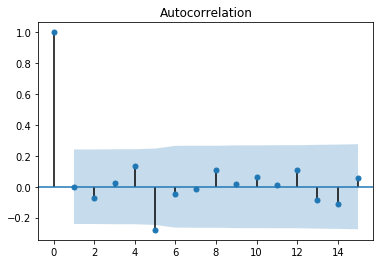

In [352]:
plot_acf(returns, lags=15)
plt.show()

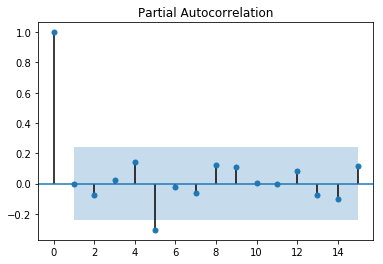

In [353]:
plot_pacf(returns, lags=15)
plt.show()

### Only lag = 5 show a little bit of statistical significance. 

### For the purpose of learning, we will choose lag = 5 for both AR and MA part of fitting ARMA model

## Now we will work on defining a method which will choose to buy or not on any particular day and sell it next day and then try to find whether we can create a strategy around this to generate returns

In [354]:
# for progress bar
from tqdm import tqdm

In [355]:
# plotting the curve where we have bought and sell next day to look whether we have made profit or loss

def plotting_strategy(prices, events_list, final_amt, init_amt):
    plt.figure(figsize=(18,6))
    plt.plot(prices)
    
    y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
    shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)
    
    for idx, event in enumerate(events_list):
        plt.axvline(event[1], color='k', linestyle='--', alpha=0.5)
#         if event[0] == 's':
#             color = 'green' if event[2] > 0 else 'red'
#             plt.fill_between(range(*shaded_y_lims), event[1], events_list[idx-1][1], color=color, alpha=0.1)
    
    tot_return = round(100*(final_amt/init_amt -1 ), 2)
    tot_return = str(tot_return) + '%'

    return

In [356]:
def run_simulation(prices, returns, amt_invested, order_of_arima, threshold, type_of_strategy):
    
    if type_of_strategy == 'random':
        threshold = None
        
    curr_holding = False
    events_list = []
    init_amt = amt_invested
    buy_price = prices.loc[returns.index[0]]
    
    for date, r in tqdm(returns.iloc[:].items(), total=len(returns.iloc[:])):
        # get data till this data as only this info is available to make decision
        curr_data = returns[:date]
        
        # if i have bought last day, then i need to sell it today
        if curr_holding:
            sell_price = prices.loc[date]
#             print(f"Sell Price is {sell_price}" )
            curr_holding = False
            ret = (sell_price - buy_price) / buy_price
            amt_invested *= (1 + ret)
            events_list.append(('s', date, ret))
            
        if type_of_strategy == 'arima':
            try:
                model = ARIMA(curr_data, order=order_of_arima).fit(maxiter=200)
                pred = model.forecast()[0][0] # next day of forecast
            except:
                pred = threshold - 1
        
        # if you pred high positive return and not holding stock, then buy it
        condition_for_random_or_arima = ( (type_of_strategy == 'random' and np.random.random() < order_of_arima) or (type_of_strategy == 'arima' and pred > threshold))
        if (not curr_holding) and condition_for_random_or_arima:
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
#             print(f"Buy Price is {buy_price}" )
            
    print(f"Total amount of {init_amt} end up as {amt_invested}")
    
#     plotting_strategy(prices, events_list, amt_invested, init_amt)
    
    return amt_invested

In [357]:
random_sample_result = [ run_simulation(prices, returns, 100, 0.5, 0.001, 'random') for _ in range(300)]

  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 98.58058409839511
Total amount of 100 end up as 94.15700755663028
Total amount of 100 end up as 97.10331315377313
Total amount of 100 end up as 106.53746115786436
Total amount of 100 end up as 105.32715045807912
Total amount of 100 end up as 98.60054302491194
Total amount of 100 end up as 85.65600904009729
Total amount of 100 end up as 94.05350500324722


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 101.0126337596709
Total amount of 100 end up as 111.00873077110487
Total amount of 100 end up as 103.61868798476732
Total amount of 100 end up as 98.28687488425716
Total amount of 100 end up as 103.28227395004035
Total amount of 100 end up as 113.53046308596878
Total amount of 100 end up as 97.07559518554068


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 111.60047633637355
Total amount of 100 end up as 102.21886385937745
Total amount of 100 end up as 98.83772991592797
Total amount of 100 end up as 98.76527923925204
Total amount of 100 end up as 92.55658755883591
Total amount of 100 end up as 94.34193619577128
Total amount of 100 end up as 91.20667647816806
Total amount of 100 end up as 96.33379463139438


100%|██████████| 66/66 [00:00<00:00, 2647.84it/s]

Total amount of 100 end up as 106.9545284644477
Total amount of 100 end up as 102.19867614641929
Total amount of 100 end up as 96.97320687919324
Total amount of 100 end up as 112.8617025320443
Total amount of 100 end up as 102.01529562544312
Total amount of 100 end up as 106.66043496447524
Total amount of 100 end up as 109.96742911371315
Total amount of 100 end up as 106.06602242882182



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 123.26298975166202
Total amount of 100 end up as 97.58622435590138
Total amount of 100 end up as 107.63486321843637
Total amount of 100 end up as 115.68867018266984
Total amount of 100 end up as 108.31041519184856
Total amount of 100 end up as 103.70019797922983
Total amount of 100 end up as 92.50767439352916
Total amount of 100 end up as 115.44423455817879


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 96.67632526320743
Total amount of 100 end up as 81.68552945912101
Total amount of 100 end up as 99.4334723591808
Total amount of 100 end up as 80.32996455858938
Total amount of 100 end up as 93.47477040957041
Total amount of 100 end up as 108.89855068401306
Total amount of 100 end up as 103.43010624358716
Total amount of 100 end up as 83.9877215334643


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 100.70189610393858
Total amount of 100 end up as 99.25965155024126
Total amount of 100 end up as 117.06525967318993
Total amount of 100 end up as 90.86297368835947
Total amount of 100 end up as 96.76245228331369
Total amount of 100 end up as 111.27742367104553
Total amount of 100 end up as 98.27854976123122
Total amount of 100 end up as 113.21210759382346


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 105.12889300090764
Total amount of 100 end up as 106.56769883779066
Total amount of 100 end up as 94.66701339428081
Total amount of 100 end up as 111.03611413782082
Total amount of 100 end up as 93.07891429309676
Total amount of 100 end up as 89.247603132638
Total amount of 100 end up as 98.52099182336394
Total amount of 100 end up as 100.90513920589378


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 102.45284303002697
Total amount of 100 end up as 95.54254054775433
Total amount of 100 end up as 90.51332152065407
Total amount of 100 end up as 111.46183885619165
Total amount of 100 end up as 108.18501829274548
Total amount of 100 end up as 86.65785532866812
Total amount of 100 end up as 106.68305066157421
Total amount of 100 end up as 98.48633483590918


100%|██████████| 66/66 [00:00<00:00, 3371.83it/s]


Total amount of 100 end up as 92.39476523674581
Total amount of 100 end up as 92.19320033697701
Total amount of 100 end up as 106.6025620173996
Total amount of 100 end up as 100.38101065037787
Total amount of 100 end up as 110.61071514562404
Total amount of 100 end up as 97.82644745299741
Total amount of 100 end up as 89.39533480446437
Total amount of 100 end up as 110.01679993008217
Total amount of 100 end up as 110.12458995371213


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 105.32678348935357
Total amount of 100 end up as 84.66908777038772
Total amount of 100 end up as 120.84783922647182
Total amount of 100 end up as 93.46296092069018
Total amount of 100 end up as 94.69512331505352
Total amount of 100 end up as 98.33347423923911
Total amount of 100 end up as 92.08352031748535
Total amount of 100 end up as 121.38467080411328


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 101.38310451396798
Total amount of 100 end up as 85.73512917948514
Total amount of 100 end up as 101.08465460282123
Total amount of 100 end up as 103.09821090477557
Total amount of 100 end up as 105.58220900241413
Total amount of 100 end up as 103.5040384624408
Total amount of 100 end up as 107.88934704099614
Total amount of 100 end up as 91.2243284261353


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 99.225201680585
Total amount of 100 end up as 98.60025118178348
Total amount of 100 end up as 92.03730906224223
Total amount of 100 end up as 93.3611005602846
Total amount of 100 end up as 106.29452841359607
Total amount of 100 end up as 101.77132347157175
Total amount of 100 end up as 107.53791705072634
Total amount of 100 end up as 114.86706808219655
Total amount of 100 end up as 87.79236557135037


100%|██████████| 66/66 [00:00<00:00, 3249.30it/s]

Total amount of 100 end up as 97.0181282741551
Total amount of 100 end up as 95.20751911680841
Total amount of 100 end up as 109.85026684835104
Total amount of 100 end up as 104.58376233346502
Total amount of 100 end up as 98.10373793402314
Total amount of 100 end up as 84.11971428045864
Total amount of 100 end up as 93.75123044030293
Total amount of 100 end up as 96.99577116071673
Total amount of 100 end up as 98.57253420721703



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 115.8506001011341
Total amount of 100 end up as 108.08990753499101
Total amount of 100 end up as 119.21824432740365
Total amount of 100 end up as 89.979324016011
Total amount of 100 end up as 97.5366563150455
Total amount of 100 end up as 110.49531107803212
Total amount of 100 end up as 106.95080513959402
Total amount of 100 end up as 103.7584544047849


100%|██████████| 66/66 [00:00<00:00, 3113.64it/s]

Total amount of 100 end up as 97.1419817230777
Total amount of 100 end up as 111.05779700975505
Total amount of 100 end up as 108.58942651743932
Total amount of 100 end up as 100.38465809958062
Total amount of 100 end up as 93.69504055523375
Total amount of 100 end up as 105.62099307042557
Total amount of 100 end up as 92.03527240274312
Total amount of 100 end up as 96.98323773864954



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 102.0833802804446
Total amount of 100 end up as 93.26684665565725
Total amount of 100 end up as 98.8408526756283
Total amount of 100 end up as 98.20073366021863
Total amount of 100 end up as 100.60995664975015
Total amount of 100 end up as 112.70724205384916
Total amount of 100 end up as 114.05005359438033
Total amount of 100 end up as 91.44687575046791


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 97.17782476783006
Total amount of 100 end up as 86.60364200951201
Total amount of 100 end up as 102.45693374943797
Total amount of 100 end up as 100.12321967245042
Total amount of 100 end up as 98.99734322517881
Total amount of 100 end up as 100.10957154845259
Total amount of 100 end up as 103.67036712820239
Total amount of 100 end up as 100.88932684796798
Total amount of 100 end up as 102.69853440642711


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 109.7846745113731
Total amount of 100 end up as 91.61131378227887
Total amount of 100 end up as 109.87900843266932
Total amount of 100 end up as 97.64278542567965
Total amount of 100 end up as 96.17580920586667
Total amount of 100 end up as 99.48321211123273
Total amount of 100 end up as 99.13219368787259
Total amount of 100 end up as 103.22900811796208
Total amount of 100 end up as 97.34333402895757


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 115.98794657609756
Total amount of 100 end up as 110.18864097062378
Total amount of 100 end up as 102.02727999149296
Total amount of 100 end up as 93.36762636449363
Total amount of 100 end up as 103.04706439859986
Total amount of 100 end up as 96.01153456718286
Total amount of 100 end up as 99.37738231883407
Total amount of 100 end up as 96.54217137125544
Total amount of 100 end up as 92.68565355795599


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 120.25510021049335
Total amount of 100 end up as 98.18540190334333
Total amount of 100 end up as 109.13476619634054
Total amount of 100 end up as 90.53159581665503
Total amount of 100 end up as 98.05351326491697
Total amount of 100 end up as 109.18132888956374
Total amount of 100 end up as 88.66407521939315
Total amount of 100 end up as 101.5278374437247


100%|██████████| 66/66 [00:00<00:00, 3119.50it/s]


Total amount of 100 end up as 107.91999725473953
Total amount of 100 end up as 99.10761698366574
Total amount of 100 end up as 115.75984775137
Total amount of 100 end up as 86.15355485100194
Total amount of 100 end up as 104.56043481956561
Total amount of 100 end up as 95.25268379713194
Total amount of 100 end up as 106.75984614261047
Total amount of 100 end up as 116.82695581500602


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 91.07027350841535
Total amount of 100 end up as 100.71383606296962
Total amount of 100 end up as 102.63716933093002
Total amount of 100 end up as 99.78401110292597
Total amount of 100 end up as 99.03109151762713
Total amount of 100 end up as 99.21867245156425
Total amount of 100 end up as 95.72054850922368
Total amount of 100 end up as 114.3008101485134


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 91.24182748216653
Total amount of 100 end up as 114.92089546447542
Total amount of 100 end up as 103.46629562223396
Total amount of 100 end up as 103.30419871033024
Total amount of 100 end up as 101.4863736808549
Total amount of 100 end up as 102.56395002482616
Total amount of 100 end up as 89.32112776409579
Total amount of 100 end up as 119.33862353111628


100%|██████████| 66/66 [00:00<00:00, 3300.99it/s]

Total amount of 100 end up as 87.65711142985019
Total amount of 100 end up as 90.38318293802006
Total amount of 100 end up as 121.80930023035657
Total amount of 100 end up as 102.56344281796213
Total amount of 100 end up as 93.9409401696298
Total amount of 100 end up as 112.83633844526507
Total amount of 100 end up as 96.69102940398409
Total amount of 100 end up as 102.62139835819775
Total amount of 100 end up as 91.45843031877142



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 104.81428401237734
Total amount of 100 end up as 98.60478554728188
Total amount of 100 end up as 107.07131555329022
Total amount of 100 end up as 102.76283082587966
Total amount of 100 end up as 101.77319228206052
Total amount of 100 end up as 102.4254167108703
Total amount of 100 end up as 97.77230171974118
Total amount of 100 end up as 90.52691180019917


100%|██████████| 66/66 [00:00<00:00, 3692.96it/s]

Total amount of 100 end up as 111.40872800038
Total amount of 100 end up as 107.10202993981402
Total amount of 100 end up as 103.99166237280487
Total amount of 100 end up as 98.06355739458942
Total amount of 100 end up as 98.93028980735339
Total amount of 100 end up as 101.06222977462437
Total amount of 100 end up as 96.09001056484892
Total amount of 100 end up as 100.39469655959044
Total amount of 100 end up as 93.35884182710446



  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 95.93698404811693
Total amount of 100 end up as 97.4910676196257
Total amount of 100 end up as 103.42307914430428
Total amount of 100 end up as 100.04056259458527
Total amount of 100 end up as 89.4431462501598
Total amount of 100 end up as 96.15177717297651
Total amount of 100 end up as 99.89454747284664
Total amount of 100 end up as 99.94841232657689
Total amount of 100 end up as 110.26700909971942


100%|██████████| 66/66 [00:00<00:00, 3225.64it/s]


Total amount of 100 end up as 97.80223725934003
Total amount of 100 end up as 99.79940829373216
Total amount of 100 end up as 104.84321523758894
Total amount of 100 end up as 98.87384158261224
Total amount of 100 end up as 94.39453445717974
Total amount of 100 end up as 105.79562061843657
Total amount of 100 end up as 93.77124723349353
Total amount of 100 end up as 114.21939333683694
Total amount of 100 end up as 110.82633536833235


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 112.49220367406845
Total amount of 100 end up as 100.91250926194564
Total amount of 100 end up as 98.95931439177593
Total amount of 100 end up as 80.54954389130462
Total amount of 100 end up as 103.41775337861888
Total amount of 100 end up as 89.74958684596672
Total amount of 100 end up as 89.46509795918884
Total amount of 100 end up as 87.20510045717762


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 102.29789360727986
Total amount of 100 end up as 108.62350783641028
Total amount of 100 end up as 109.89148818747339
Total amount of 100 end up as 90.53624651359075
Total amount of 100 end up as 97.72038589823583
Total amount of 100 end up as 93.5077806930867
Total amount of 100 end up as 101.72733056836529
Total amount of 100 end up as 119.07732496045847


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 95.54296925245117
Total amount of 100 end up as 102.97189212466063
Total amount of 100 end up as 80.85923209266089
Total amount of 100 end up as 98.04065714640582
Total amount of 100 end up as 99.78318088981383
Total amount of 100 end up as 98.42887469196071
Total amount of 100 end up as 91.11354763149163
Total amount of 100 end up as 110.37120654897939


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 93.70094095221476
Total amount of 100 end up as 109.55455896888246
Total amount of 100 end up as 89.14291583959262
Total amount of 100 end up as 119.69470019691717
Total amount of 100 end up as 102.1945873160768
Total amount of 100 end up as 99.45114740922828
Total amount of 100 end up as 105.02322738940259
Total amount of 100 end up as 105.01434662043002
Total amount of 100 end up as 95.72948011753778


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 107.1557103078289
Total amount of 100 end up as 103.00845011334938
Total amount of 100 end up as 94.01594868947646
Total amount of 100 end up as 92.55230994859676
Total amount of 100 end up as 108.62668699202615
Total amount of 100 end up as 101.71501206244056
Total amount of 100 end up as 101.68608665601062
Total amount of 100 end up as 118.03247691816549
Total amount of 100 end up as 103.08726618102075


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 110.01628934161222
Total amount of 100 end up as 114.87209878857344
Total amount of 100 end up as 109.28670927146375
Total amount of 100 end up as 91.65561185395462
Total amount of 100 end up as 92.07029784671053
Total amount of 100 end up as 96.53524358846467
Total amount of 100 end up as 87.0237512038795
Total amount of 100 end up as 84.9489416398965


100%|██████████| 66/66 [00:00<00:00, 3356.75it/s]

Total amount of 100 end up as 102.04139025513078
Total amount of 100 end up as 92.71859880322306
Total amount of 100 end up as 106.13033866327585
Total amount of 100 end up as 99.43053083098987
Total amount of 100 end up as 103.34634184072273
Total amount of 100 end up as 98.31500901328086
Total amount of 100 end up as 83.71863863496726
Total amount of 100 end up as 103.30555777641558
Total amount of 100 end up as 95.27261565824364


Text(0.5, 1.0, 'Avg : 100.8, Invested : 100 \n SD : 8.4')

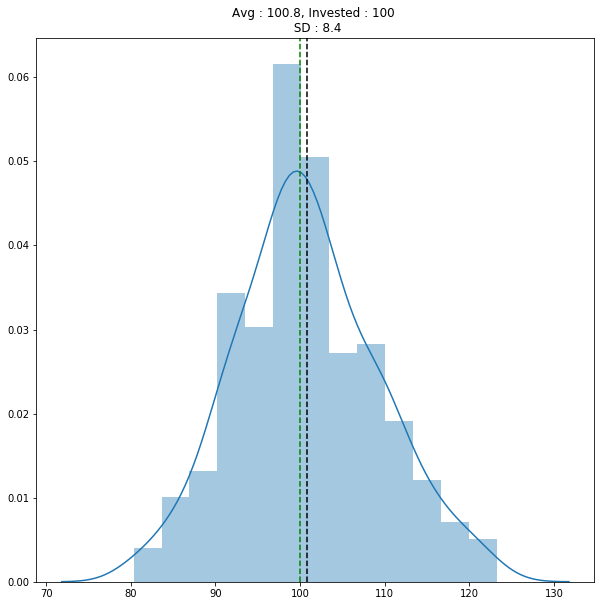

In [358]:
# distribution of results
plt.figure(figsize=(10,10))
sns.distplot(random_sample_result)
plt.axvline(np.mean(random_sample_result), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title(f"Avg : {round(np.mean(random_sample_result), 2)}, Invested : 100 \n SD : {round(np.std(random_sample_result),2)}")

## ARIMA (1, 0, 0)


In [359]:
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning

# these are some of the exception that are there in the fitting fo stats model that you can just suppress for learning purpose using warnings ignore

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [360]:
result_ar_1 = []
for thresh in [0, 0.001, 0.005]:
    result_ar_1.append(run_simulation(prices, returns, 100, (1,0,0), thresh, 'arima'))

  6%|▌         | 4/66 [00:00<00:03, 20.54it/s]

Total amount of 100 end up as 93.36450288460895


  6%|▌         | 4/66 [00:00<00:01, 31.66it/s]

Total amount of 100 end up as 91.95342893795508


100%|██████████| 66/66 [00:03<00:00, 20.59it/s]

Total amount of 100 end up as 94.76407122793819


In [361]:
# performed worse
result_ar_1

[93.36450288460895, 91.95342893795508, 94.76407122793819]

## ARIMA (5,0,0)

In [362]:
result_ar_5 = []
for thresh in [0, 0.001, 0.005]:
    result_ar_5.append(run_simulation(prices, returns, 100, (5,0,0), thresh, 'arima'))

  0%|          | 0/66 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
 21%|██        | 14/66 [00:02<00:20,  2.54it/s]/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:60

Total amount of 100 end up as 106.40848395680632


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 104.29632116087826


100%|██████████| 66/66 [00:30<00:00,  1.92it/s]

Total amount of 100 end up as 112.26154369387719


## AR and MA together as ARIMA (5,0,5)

In [363]:
result_ar_5_ma_5 = []
for thresh in [0, 0.001, 0.005]:
    result_ar_5_ma_5.append(run_simulation(prices, returns, 100, (5,0,5), thresh, 'arima'))

  0%|          | 0/66 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hes

Total amount of 100 end up as 98.5005375884124


  0%|          | 0/66 [00:00<?, ?it/s]

Total amount of 100 end up as 98.09213426757394


100%|██████████| 66/66 [00:43<00:00,  1.88s/it]

Total amount of 100 end up as 99.31112393048113


In [364]:
result_ar_1

[93.36450288460895, 91.95342893795508, 94.76407122793819]

In [365]:
result_ar_5

[106.40848395680632, 104.29632116087826, 112.26154369387719]

In [366]:
result_ar_5_ma_5

[98.5005375884124, 98.09213426757394, 99.31112393048113]

In [367]:
# some results are quite good but that may be because of the data set that we choose